In [ ]:
# torch==1.4.0 
# torchvision==0.5.0

In [ ]:
import os
path = ""
os.chdir(path + '\celeba')

In [ ]:
if not os.path.exists("save_image"):
    os.mkdir("save_image")
if not os.path.exists("asset"):
    os.mkdir("asset")
if not os.path.exists("train"):
    os.mkdir("train")
if not os.path.exists("train/image"):
    os.mkdir("train/image")
if not os.path.exists("test"):
    os.mkdir("test")
if not os.path.exists("test/image"):
    os.mkdir("test/image")

In [ ]:
import glob

files = glob.glob("img_align_celeba/*.jpg")
print(len(files))

29120


In [ ]:
import matplotlib.pyplot as plt
import random
import cv2
from google.colab.patches import cv2_imshow

## SRGAN

In [ ]:
from sklearn.model_selection import train_test_split

sample_num = 50
test_size = 0.3

# ValueError が出たら files = glob.glob("img_align_celeba/*.jpg") から再実行
sample_files = random.sample(files, sample_num)

train_files, test_files = train_test_split(sample_files, test_size=test_size)
print(len(train_files), len(test_files))

35 15


0 0
TRAIN
(178, 178, 3)


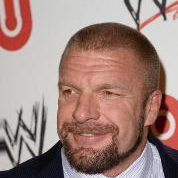

(178, 178, 3)


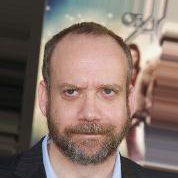

(178, 178, 3)


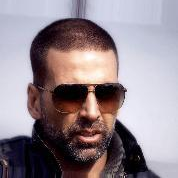

(178, 178, 3)


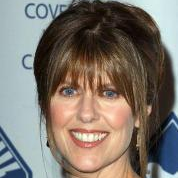

(178, 178, 3)


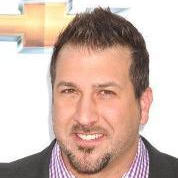

(178, 178, 3)


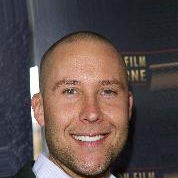

(178, 178, 3)


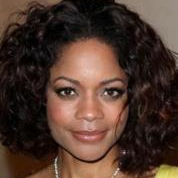

TEST
(178, 178, 3)


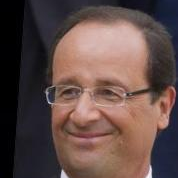

(178, 178, 3)


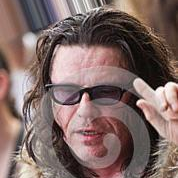

(178, 178, 3)


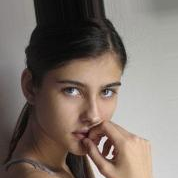

In [ ]:
train = glob.glob("train/image/*.jpg")
test = glob.glob("test/image/*.jpg")

print(len(train), len(test))

interval = sample_num / 10

if len(train) < sample_num * (1-test_size):
    # train用データセットの抽出
    print("TRAIN")
    for i, file in enumerate(train_files):
        img = cv2.imread(file, cv2.IMREAD_UNCHANGED)

        height = img.shape[0]
        width = img.shape[1]
        crop_size = abs(height - width)//2

        if height > width:
            img = img[crop_size:height-crop_size, 0:width]
        else:
            img = img[0:height, crop_size:width-crop_size]

        cv2.imwrite("train/image/" + file.split("/")[1], img)
        # 間隔を置いてサンプルで表示
        if i % interval == 0:
            print(img.shape)
            cv2_imshow(img)

if len(test) < sample_num * test_size:
    # test用データセットの抽出
    print("TEST")
    for i, file in enumerate(test_files):
        img = cv2.imread(file, cv2.IMREAD_UNCHANGED)

        height = img.shape[0]
        width = img.shape[1]
        crop_size = abs(height - width)//2

        if height > width:
            img = img[crop_size:height-crop_size, 0:width]
        else:
            img = img[0:height, crop_size:width-crop_size]

        cv2.imwrite("test/image/" + file.split("/")[1], img)
        # 間隔を置いてサンプルで表示
        if i % interval == 0:
            print(img.shape)
            cv2_imshow(img)

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch
import os
import torch.utils.data
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.nn import functional as F
import numpy as np
from torchvision.utils import save_image

%matplotlib inline
# from torchvision.models.vgg import vgg16
from torchvision.models.mobilenet import mobilenet_v2

cuda = torch.cuda.is_available()
if cuda:
    print('cuda is available!')

cuda is available!


In [ ]:
class DownSizePairImageFolder(ImageFolder):
    def __init__(self, root, transform=None, large_size=256, middle_size=64, small_size=32, **kwds):
        super().__init__(root, transform=transform, **kwds)
        self.large_resizer = transforms.Resize(large_size)
        self.small_resizer = transforms.Resize(small_size)
        self.middle_resizer = transforms.Resize(middle_size)
        
    def __getitem__(self, index):
        path, _ = self.imgs[index]
        img = self.loader(path)
        large_img = self.large_resizer(img)
        small_img = self.small_resizer(img)
        middle_img = self.middle_resizer(small_img)
        if self.transform is not None:
            large_img = self.transform(large_img)
            small_img = self.transform(small_img)
            middle_img = self.transform(middle_img)
        return middle_img, large_img

In [ ]:
train_data = DownSizePairImageFolder(root=os.getcwd() + "/train", transform=transforms.ToTensor())
test_data = DownSizePairImageFolder(root=os.getcwd() + "/test", transform=transforms.ToTensor())
batch_size = 1
train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size, shuffle=False, num_workers=2)

torch.Size([3, 256, 256])
0.8901961 0.0


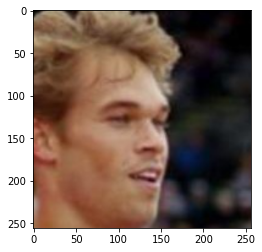

In [ ]:
images_lr, images_hr = iter(train_loader).next()
image=images_hr[0]
print(image.size())
image_np=image.numpy()
print(image_np.max(),image_np.min())
image_np=np.transpose(image_np,(1,2,0))
plt.imshow(image_np)

torch.Size([3, 64, 64])
0.8156863 0.0


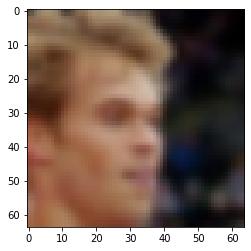

In [ ]:
image=images_lr[0]
print(image.size())
image_np=image.numpy()
print(image_np.max(),image_np.min())
image_np=np.transpose(image_np,(1,2,0))
plt.imshow(image_np)

In [ ]:
class Generator(nn.Module):
    def __init__(self,image_size):
        super(Generator,self).__init__()
        self.image_size=image_size
        
        self.pre_layer=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=9,stride=1,padding=4),
            nn.PReLU())
        
        self.residual_layer=nn.Sequential(
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64))
        
        self.middle_layer=nn.Sequential(
            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64))
        
        self.pixcelshuffer_layer=nn.Sequential(
            Pixcelshuffer(64,2),
            Pixcelshuffer(64,2),
            nn.Conv2d(64,3,kernel_size=9,stride=1,padding=4))
    def forward(self,input_image):
        pre=self.pre_layer(input_image)
        res=self.residual_layer(pre)
        middle=self.middle_layer(res)
        middle=middle+pre
        output=self.pixcelshuffer_layer(middle)
        
        return output

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self,input_channel):
        super(ResidualBlock,self).__init__()
        
        self.residualblock=nn.Sequential(
            nn.Conv2d(input_channel,input_channel,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(input_channel),
            nn.PReLU(),
            nn.Conv2d(input_channel,input_channel,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(input_channel))
    def forward(self,x):
        residual=self.residualblock(x)
        
        return x+residual

In [ ]:
class Pixcelshuffer(nn.Module):
    def __init__(self,input_channel,r): #r=upscale_factor
        super(Pixcelshuffer,self).__init__()
        
        self.layer=nn.Sequential(
            nn.Conv2d(input_channel,256,kernel_size=3,stride=1,padding=1), 
            nn.PixelShuffle(r),
            nn.PReLU())
    def forward(self,x):
        return self.layer(x)

In [ ]:
test_input=torch.ones(1,3,64,64)
g=Generator(64)
if cuda:
    test_input=test_input.cuda()
    g=g.cuda()
out=g(test_input)
print(out.size())

torch.Size([1, 3, 256, 256])


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        
        self.conv_layers=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64,64,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128,128,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256,256,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(512,512,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2))#(512,316,16)
        
        self.dense_layer=nn.Sequential(
            nn.Linear(16*16*512,1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024,1),
            nn.Sigmoid())
        
    def forward(self,input_image):
        batch_size=input_image.size()[0]
        
        conv=self.conv_layers(input_image)
        reshape=conv.view(batch_size,-1)
        output=self.dense_layer(reshape)
        
        return output

In [ ]:
test_input=torch.ones(1,3,256,256)
d=Discriminator()
if cuda:
    test_input=test_input.cuda()
    d=d.cuda()
out=d(test_input)
print(out.size())

torch.Size([1, 1])


In [ ]:
def generator_loss(generated_image,hr_image,d_label,t_label):
    # vgg=vgg16(pretrained=True) 
    # content_layers=nn.Sequential(*list(vgg.features)[:31]).eval()
    mobile = mobilenet_v2(pretrained=True)
    content_layers=nn.Sequential(*list(mobile.features)[:18]).eval()
    if cuda:
        content_layers=content_layers.cuda()
    for param in content_layers.parameters():
        param.requires_grad=False
    mse_loss=nn.MSELoss()
    content_loss=mse_loss(content_layers(generated_image),content_layers(hr_image))
    
    BCE_loss=nn.BCELoss()
    adversarial_loss=BCE_loss(d_label,t_label)
    
    return content_loss+0.001*adversarial_loss

In [ ]:
def MSE_Loss(generated_image,hr_image):
    mse_loss=nn.MSELoss()
    image_loss=mse_loss(generated_image,hr_image)
    
    return image_loss

In [ ]:
G=Generator(64)
D=Discriminator()

if cuda:
    G=G.cuda()
    D=D.cuda()
G_optimizer=optim.Adam(G.parameters(),lr=0.0001,betas=(0.9,0.999))

In [ ]:
def first_train(epoch):
    G.train()

    G_loss=0

    for batch_idx,(data_lr,data_hr)in enumerate(train_loader):
        if data_lr.size()[0]!=batch_size:
            break
        if cuda:
            data_lr=data_lr.cuda()
            data_hr=data_hr.cuda()
        fake_image=G(data_lr)
        G.zero_grad()

        G_loss=MSE_Loss(fake_image,data_hr)
        G_loss.backward()
        G_optimizer.step()
        G_loss+=G_loss.data

        G_loss/=len(train_loader)

        g_image=fake_image.data.cpu()
        hr_image=data_hr.data.cpu()
        HR_image=torch.cat((hr_image,g_image),0)

        if epoch%100==0:
            save_image(HR_image,os.getcwd()+"/save_image/epoch_{}.png".format(epoch))
            print("save_image")

        return G_loss

num_epoch=10000

for epoch in range(1,num_epoch+1):
    if epoch==1:
        print("trainning start!!")
    g_loss_=first_train(epoch)

    if epoch%10==0:
        print(f"{epoch} / {num_epoch}, {round(epoch/num_epoch*100, 2)}%")

    if epoch%1000==0:
        torch.save(G.state_dict(),os.getcwd()+"/asset/G_first_epoch{}.pth".format(epoch))

trainning start!!
10 / 10000, 0.1%
20 / 10000, 0.2%
30 / 10000, 0.3%
40 / 10000, 0.4%
50 / 10000, 0.5%
60 / 10000, 0.6%
70 / 10000, 0.7%
80 / 10000, 0.8%
90 / 10000, 0.9%
save_image
100 / 10000, 1.0%
110 / 10000, 1.1%
120 / 10000, 1.2%
130 / 10000, 1.3%
140 / 10000, 1.4%
150 / 10000, 1.5%
160 / 10000, 1.6%
170 / 10000, 1.7%
180 / 10000, 1.8%
190 / 10000, 1.9%
save_image
200 / 10000, 2.0%
210 / 10000, 2.1%
220 / 10000, 2.2%
230 / 10000, 2.3%
240 / 10000, 2.4%
250 / 10000, 2.5%
260 / 10000, 2.6%
270 / 10000, 2.7%
280 / 10000, 2.8%
290 / 10000, 2.9%
save_image
300 / 10000, 3.0%
310 / 10000, 3.1%
320 / 10000, 3.2%
330 / 10000, 3.3%
340 / 10000, 3.4%
350 / 10000, 3.5%
360 / 10000, 3.6%
370 / 10000, 3.7%
380 / 10000, 3.8%
390 / 10000, 3.9%
save_image
400 / 10000, 4.0%
410 / 10000, 4.1%
420 / 10000, 4.2%
430 / 10000, 4.3%
440 / 10000, 4.4%
450 / 10000, 4.5%
460 / 10000, 4.6%
470 / 10000, 4.7%
480 / 10000, 4.8%
490 / 10000, 4.9%
save_image
500 / 10000, 5.0%
510 / 10000, 5.1%
520 / 10000, 5.2%


In [ ]:
test_loader = DataLoader(test_data, batch_size, shuffle=True)
images_lr, images_hr = iter(test_loader).next()

generated_image=G(images_lr.cuda())
bl_recon=torch.nn.functional.upsample(images_lr,256,mode="bilinear")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [ ]:
G=Generator(64)
D=Discriminator()

if cuda:
    G=G.cuda()
    D=D.cuda()

    g_param=torch.load(os.getcwd()+f"/asset/G_first_epoch{num_epoch}.pth")
    G.load_state_dict(g_param)
else:
    g_param=torch.load(os.getcwd()+f"/asset/G_first_epoch{num_epoch}.pth",
                       map_location=lambda storage, loc:storage)
    G.load_state_dict(g_param)

    
G_optimizer=optim.Adam(G.parameters(),lr=0.0001,betas=(0.9,0.999))
D_optimizer=optim.Adam(D.parameters(),lr=0.0001,betas=(0.9,0.999))

d_loss=nn.BCELoss()

In [ ]:
import time
torch.cuda.synchronize()
start = time.time()

In [ ]:
def train(epoch):
    D.train()
    G.train()

    y_real=torch.ones(batch_size,1)
    y_fake=torch.zeros(batch_size,1)

    if cuda:
        y_real=y_real.cuda()
        y_fake=y_fake.cuda()

        D_loss=0
        G_loss=0

    for batch_idx,(data_lr,data_hr)in enumerate(train_loader):
        if data_lr.size()[0]!=batch_size:
            break
        if cuda:
            data_lr=data_lr.cuda()
            data_hr=data_hr.cuda()
        print(batch_idx)
        D.zero_grad()

        D_real=D(data_hr)
        D_real_loss=d_loss(D_real,y_real)

        fake_image=G(data_lr)
        D_fake=D(fake_image)
        D_fake_loss=d_loss(D_fake,y_fake)

        D_loss=(D_real_loss+D_fake_loss)
        D_loss.backward(retain_graph=True)
        D_optimizer.step()
        D_loss+=D_loss.data

        G.zero_grad()

        G_loss=generator_loss(fake_image,data_hr,D_fake,y_real).clone()
        print(G_loss,D_loss)
        G_loss.backward()
        G_optimizer.step()
        G_loss+=G_loss.data

        D_loss/=len(train_loader)
        G_loss/=len(train_loader)

        if batch_idx%1==0:
            g_image=fake_image.data.cpu()
            hr_image=data_hr.data.cpu()
            HR_image=torch.cat((hr_image,g_image),0)

            if epoch%100==0:
                save_image(HR_image,"save_image/epoch_cont_{}.png".format(epoch))
                print("save_image")

        return D_loss,G_loss

num_epoch=10000

for epoch in range(1,num_epoch+1):
    if epoch==1:
        print("trainning start!!")
    d_loss_,g_loss_=train(epoch)

    if epoch%10==0:
        print()
        print(f"{epoch} / {num_epoch}, {round(epoch/num_epoch*100, 2)}%")
        print()

    elif epoch%1000==0:
        #generate_image(epoch)
        torch.save(G.state_dict(),"asset/G_2nd_epoch{}.pth".format(epoch))
        torch.save(D.state_dict(),"asset/D_2nd_epoch{}.pth".format(epoch))

ストリーミング出力は最後の 5000 行に切り捨てられました。
tensor(0.0102, device='cuda:0', grad_fn=<CloneBackward>) tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)
0
tensor(0.0185, device='cuda:0', grad_fn=<CloneBackward>) tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
0
tensor(0.0178, device='cuda:0', grad_fn=<CloneBackward>) tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
0
tensor(0.0140, device='cuda:0', grad_fn=<CloneBackward>) tensor(0.1143, device='cuda:0', grad_fn=<AddBackward0>)

7840 / 10000, 78.4%

0
tensor(0.0047, device='cuda:0', grad_fn=<CloneBackward>) tensor(0.3836, device='cuda:0', grad_fn=<AddBackward0>)
0
tensor(0.0296, device='cuda:0', grad_fn=<CloneBackward>) tensor(4.2586, device='cuda:0', grad_fn=<AddBackward0>)
0
tensor(0.0090, device='cuda:0', grad_fn=<CloneBackward>) tensor(0.0033, device='cuda:0', grad_fn=<AddBackward0>)
0
tensor(0.0085, device='cuda:0', grad_fn=<CloneBackward>) tensor(0.0045, device='cuda:0', grad_fn=<AddBackward0>)
0
tensor(0.0170, device='cud

In [ ]:
# 測定したい部分終了
torch.cuda.synchronize()
elapsed_time = time.time() - start

print(elapsed_time, 'sec.')

12274.85264492035 sec.


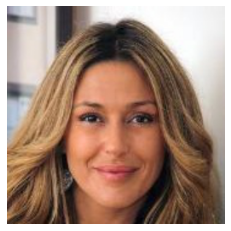

In [ ]:
### 高解像度画像
img = images_hr.to('cpu').detach().numpy().reshape(3, 256, 256).transpose(1, 2, 0)

plt.axis("off")
plt.imshow(img)

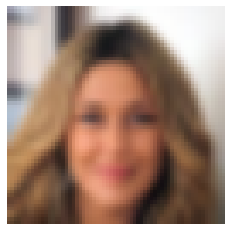

In [ ]:
### 低解像度画像
img = images_lr.to('cpu').detach().numpy().reshape(3, 64, 64).transpose(1, 2, 0)

plt.axis("off")
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


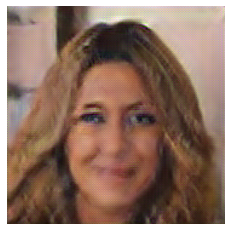

In [ ]:
generated_image=G(images_lr.cuda())

img = generated_image.cpu().detach().numpy().reshape(3, 256, 256).transpose(1, 2, 0)

plt.axis("off")
plt.imshow(img)

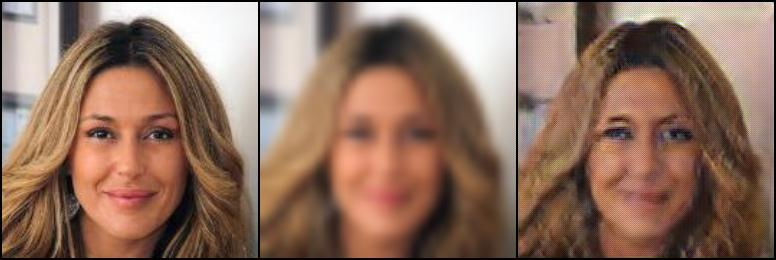

In [ ]:
save_image(torch.cat([images_hr,bl_recon.cpu(),generated_image.cpu()],0),"asset/result1.jpg")

img = cv2.imread("asset/result1.jpg", cv2.IMREAD_UNCHANGED)
cv2_imshow(img)